**1. Znajdź i opisz/przetestuj/może rozwiń inne ciekawe zastosowanie biblioteki pyTorch/Tensorflow (można wykorzystać dostępne kody z Internetu)**

Pierwszy model będzie służyć do przewidywania zdarzeń i wartości w dziedzine czasu (Time-series forecasting). Do tego zadania użyję sieci LSTM (long short-term memory), jest to rekurencyjna sieć neuronowa często używana do tego typu zadań oraz do zadań z zakresu NLP (przetwarzanie języka naturalnego).
Time-series forecasting jest na przykład używane do przewidywania cen akcji w czasie, aby móc sprzedać z największym zyskiem. 

Ten przykład będzie używać danych wygenerowanych za pomocą numpy, będą to zwykłe sinusoidy. Można sobie wyobrazić, że to ceny jakiejś spółki na giełdzie.

Generuję dane
https://github.com/pytorch/examples/tree/master/time_sequence_prediction

In [1]:
import numpy as np
import torch

np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('-f')
    parser.add_argument('--steps', type=int, default=15, help='steps to run')
    opt = parser.parse_args()
    # set random seed to 0
    np.random.seed(0)
    torch.manual_seed(0)
    # load data and make training set
    data = torch.load('traindata.pt')
    input = torch.from_numpy(data[3:, :-1])
    target = torch.from_numpy(data[3:, 1:])
    test_input = torch.from_numpy(data[:3, :-1])
    test_target = torch.from_numpy(data[:3, 1:])
    # build the model
    seq = Sequence()
    seq.double()
    criterion = nn.MSELoss()
    # use LBFGS as optimizer since we can load the whole data to train
    optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
    #begin to train
    for i in range(opt.steps):
        print('STEP: ', i)
        def closure():
            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
        # begin to predict, no need to track gradient here
        with torch.no_grad():
            future = 1000
            pred = seq(test_input, future=future)
            loss = criterion(pred[:, :-future], test_target)
            print('test loss:', loss.item())
            y = pred.detach().numpy()
        # draw the result
        plt.figure(figsize=(30,10))
        plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        def draw(yi, color):
            plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
            plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
        draw(y[0], 'r')
        draw(y[1], 'g')
        draw(y[2], 'b')
        plt.savefig('predict%d.pdf'%i)
        plt.close()

STEP:  0
loss: 0.5023738120466186
loss: 0.49856639324547236
loss: 0.47901196020146203
loss: 0.44633490395179287
loss: 0.3540631027261265
loss: 0.20507018018165263
loss: 1.3960544675936455
loss: 0.03249442160928468
loss: 0.02993487897293395
loss: 0.028326823118628365
loss: 0.02683061575789482
loss: 0.023771207077302382
loss: 0.018901421315100114
loss: 0.010646824595743894
loss: 0.008725753397927045
loss: 0.007872182058727216
loss: 0.0054778439732580935
loss: 0.004051934991144067
loss: 0.002729627050900866
loss: 0.0015402697323594727
test loss: 0.0013000894101894403
STEP:  1
loss: 0.0012797663945830727
loss: 0.0011690563508991638
loss: 0.0011498925364591742
loss: 0.0011288249265203711
loss: 0.001063054928950733
loss: 0.0009563977558897424
loss: 0.0008210794177759273
loss: 0.0007670824741782477
loss: 0.0007294732960392063
loss: 0.000724657484376891
loss: 0.0007206232232254016
loss: 0.0007126712488194416
loss: 0.0006961347274589566
loss: 0.0006641155429862436
loss: 0.0006101283738644087
lo

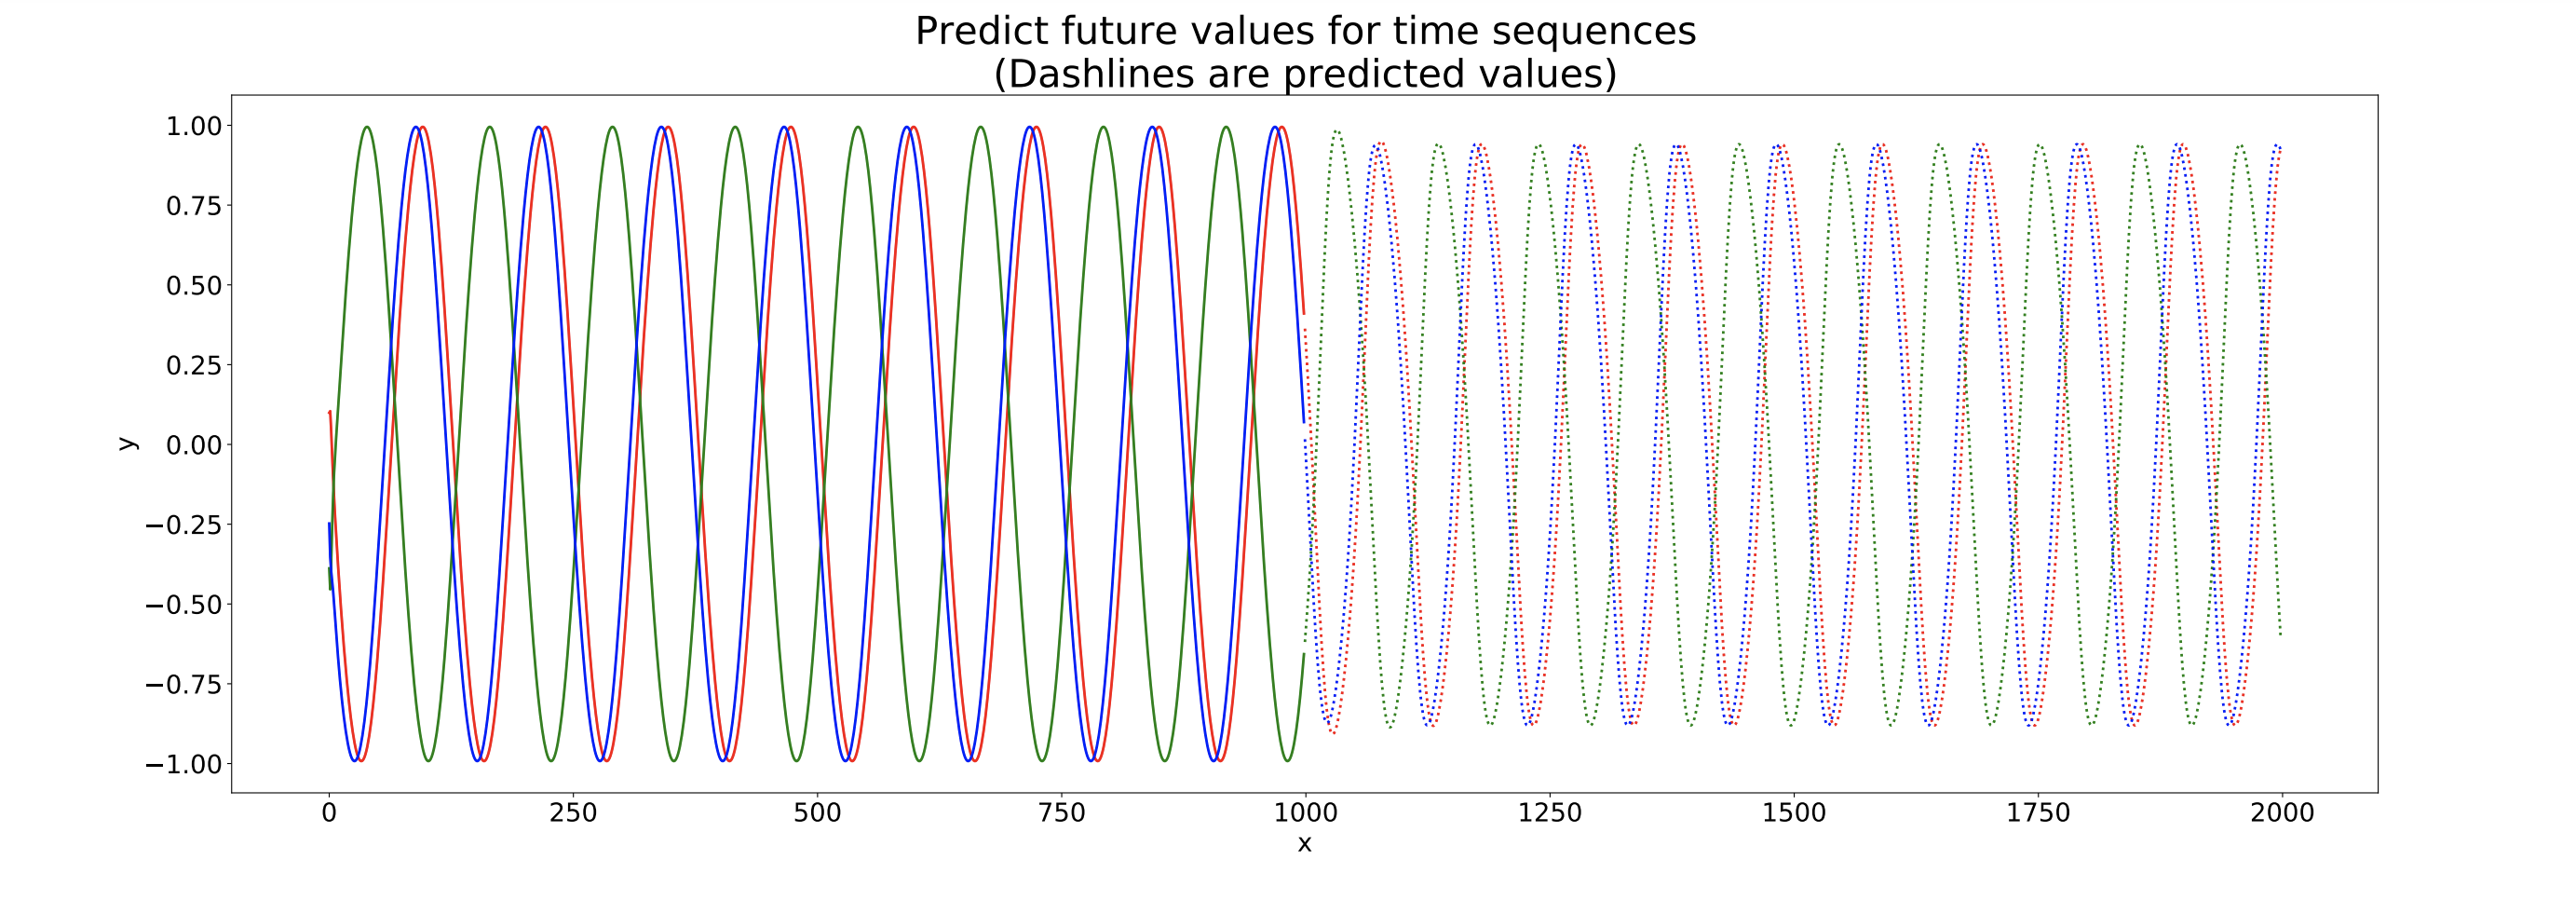

Linie zakropkowane to fale, którymi sieć nie została zasilona, te które trzeba przewidzieć. Jak widać sieć poprawnie zgaduje dalsze fale, które się jeszcze "nie wydarzyły"

**2. Znajdź i opisz/przetestuj/może rozwiń inne ciekawe zastosowanie biblioteki pyTorch/Tensorflow (można wykorzystać dostępne kody z Internetu)**

Użyjemy scikitlearn do przewidzenia, czy ktos wygra w szachy
https://www.kaggle.com/ananthr1/chess-win-or-nonwin

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/chess'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/chess/kr-vs-kp.data


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [11]:
df=pd.read_csv("/content/chess/kr-vs-kp.data")
df

,f,f.1,f.2,f.3,f.4,f.5,f.6,f.7,f.8,f.9,f.10,f.11,l,f.12,n,f.13,f.14,t,f.15,f.16,f.17,f.18,f.19,f.20,f.21,t.1,f.22,f.23,f.24,f.25,f.26,f.27,f.28,t.2,t.3,n.1,won
0,f,f,f,f,t,f,f,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,t,t,n,won
1,f,f,f,f,t,f,t,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,t,t,n,won
2,f,f,f,f,f,f,f,f,t,f,f,f,l,f,n,f,f,t,f,f,f,t,f,f,f,t,f,f,f,f,f,f,f,t,t,n,won
3,f,f,f,f,f,f,f,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,t,f,t,f,f,f,f,f,f,f,t,t,n,won
4,f,f,f,f,f,f,f,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,t,f,t,f,f,f,t,f,f,f,t,t,n,won
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,t,f,f,f,f,f,t,f,f,f,f,t,l,f,b,f,f,t,f,f,f,f,t,t,f,t,f,f,t,f,f,t,f,t,f,n,nowin
3191,t,f,f,f,f,f,t,f,f,f,f,t,l,f,b,f,f,t,f,f,f,f,t,f,f,t,f,f,t,f,f,t,f,t,f,n,nowin
3192,t,f,f,f,f,f,t,f,f,f,f,t,l,f,n,f,f,t,f,f,f,f,t,f,f,t,f,f,t,f,f,t,f,t,f,n,nowin
3193,t,f,t,f,f,f,t,f,f,f,f,t,l,t,b,t,f,t,f,f,f,f,f,t,f,t,f,f,t,f,f,t,f,f,f,n,nowin


In [12]:
df.describe()

,f,f.1,f.2,f.3,f.4,f.5,f.6,f.7,f.8,f.9,f.10,f.11,l,f.12,n,f.13,f.14,t,f.15,f.16,f.17,f.18,f.19,f.20,f.21,t.1,f.22,f.23,f.24,f.25,f.26,f.27,f.28,t.2,t.3,n.1,won
count,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195,3195
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,f,f,f,f,f,f,f,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,t,t,n,won
freq,2838,2970,3075,2873,2128,1721,2025,2499,1979,2224,1816,2859,2204,3180,2525,3039,3098,2195,3169,2713,2611,2555,3012,1974,3184,2215,3020,3194,3148,3059,2630,3020,1983,2006,2344,2406,1668


In [13]:
df.isnull().sum()

f       0
f.1     0
f.2     0
f.3     0
f.4     0
f.5     0
f.6     0
f.7     0
f.8     0
f.9     0
f.10    0
f.11    0
l       0
f.12    0
n       0
f.13    0
f.14    0
t       0
f.15    0
f.16    0
f.17    0
f.18    0
f.19    0
f.20    0
f.21    0
t.1     0
f.22    0
f.23    0
f.24    0
f.25    0
f.26    0
f.27    0
f.28    0
t.2     0
t.3     0
n.1     0
won     0
dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
col=['f', 'f.1', 'f.2', 'f.3', 'f.4', 'f.5', 'f.6', 'f.7', 'f.8', 'f.9',
       'f.10', 'f.11', 'l', 'f.12', 'n', 'f.13', 'f.14', 't', 'f.15', 'f.16',
       'f.17', 'f.18', 'f.19', 'f.20', 'f.21', 't.1', 'f.22', 'f.23', 'f.24',
       'f.25', 'f.26', 'f.27', 'f.28', 't.2', 't.3', 'n.1', 'won']
for i in col:
    df[i]=LabelEncoder().fit_transform(df[i])

In [16]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae,median_absolute_error as mee,classification_report as cr,accuracy_score as ac

In [17]:
df.columns


Index(['f', 'f.1', 'f.2', 'f.3', 'f.4', 'f.5', 'f.6', 'f.7', 'f.8', 'f.9',
       'f.10', 'f.11', 'l', 'f.12', 'n', 'f.13', 'f.14', 't', 'f.15', 'f.16',
       'f.17', 'f.18', 'f.19', 'f.20', 'f.21', 't.1', 'f.22', 'f.23', 'f.24',
       'f.25', 'f.26', 'f.27', 'f.28', 't.2', 't.3', 'n.1', 'won'],
      dtype='object')

In [18]:
x=df[['f', 'f.1', 'f.2', 'f.3', 'f.4', 'f.5', 'f.6', 'f.7', 'f.8', 'f.9',
       'f.10', 'f.11', 'l', 'f.12', 'n', 'f.13', 'f.14', 't', 'f.15', 'f.16',
       'f.17', 'f.18', 'f.19', 'f.20', 'f.21', 't.1', 'f.22', 'f.23', 'f.24',
       'f.25', 'f.26', 'f.27', 'f.28', 't.2', 't.3', 'n.1']]
y=df[['won']]

In [19]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=40)

In [20]:
from sklearn.tree import DecisionTreeClassifier 
model=DecisionTreeClassifier()

In [21]:
model.fit(x_train,y_train)
y_pre1 = model.predict(x_test)
y_pre1

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,

In [22]:
from sklearn.model_selection import cross_val_score
print(ac(y_test,y_pre1)*100)
sco1=(cross_val_score(model,x,y,cv=5))
print(np.mean(sco1)*100)

99.49937421777221
97.65258215962443


Jak widać przwidujemy wynik z całkiem dobrą dokładnością na poziomie ~97.65%